In [1]:
# A1 - Neural Networks and Regression (Hyperparameter Experiments)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from NeuralNet import NeuralNet   # custom BP implementation (from scratch)


In [8]:
# Load dataset (Bike Sharing - hourly, preprocessed/encoded)
hours = pd.read_csv("hours_encoded.csv")

# We use cnt_log as the regression target (drop original cnt)
hours = hours.drop(columns=["cnt"])

# Shuffle and take first 1500 samples, as required
hours = hours.sample(n=1500, random_state=42).reset_index(drop=True)

# Separate features and target
X_df = hours.drop(columns=["cnt_log"])
y = hours["cnt_log"].values

print("Data shape:", X_df.shape)
print("Target shape:", y.shape)
print("Columns:", X_df.columns.tolist())


Data shape: (1500, 61)
Target shape: (1500,)
Columns: ['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'season_1', 'season_2', 'season_3', 'season_4', 'yr_0', 'yr_1', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4']


In [9]:
# Global split:
#  - 80% -> train+validation
#  - 20% -> test
X_trainval_df, X_test_df, y_trainval, y_test = train_test_split(
    X_df, y,
    test_size=0.20,
    shuffle=True,
    random_state=42
)

print("Train+Val samples:", X_trainval_df.shape[0])
print("Test samples:     ", X_test_df.shape[0])


Train+Val samples: 1200
Test samples:      300


In [10]:
# Convert to numpy
X_trainval = X_trainval_df.values
X_test = X_test_df.values

# Feature scaling (fit on train+val, apply to both train+val and test)
x_scaler = StandardScaler()
X_trainval_np = x_scaler.fit_transform(X_trainval)
X_test_np     = x_scaler.transform(X_test)

# Target scaling (fit on train+val, apply to both train+val and test)
y_scaler = StandardScaler()
y_trainval_scaled = y_scaler.fit_transform(y_trainval.reshape(-1, 1)).ravel()
y_test_scaled     = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

n_features = X_trainval_np.shape[1]
print("Number of input features:", n_features)


Number of input features: 61


In [11]:
def predict_batch(model, X):
    """
    Run model.predict on each sample in X and stack results as a column vector.
    """
    return np.array([model.predict(x) for x in X]).reshape(-1, 1)

def mape(y_true, y_pred):
    """
    Safe MAPE implementation (ignores zero targets).
    """
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0


In [12]:
def run_experiment(hidden_layers, epochs, lr, momentum,
                   activation='tanh', val_split=0.2):
    """
    Runs one BP experiment on the Bike Sharing data using the custom NeuralNet.

    Outside the NeuralNet class:
      - We split the dataset into:
            80% -> train+validation (X_trainval_np, y_trainval_scaled)
            20% -> test           (X_test_np, y_test_scaled)

    Inside the NeuralNet class:
      - val_split controls the percentage of validation inside the 80%.
      - The class automatically shuffles and splits the 80% into:
            (1 - val_split) -> internal training
            val_split       -> internal validation

    This function:
      - trains the network on the 80% (with internal train/val),
      - computes predictions on the 80% and on the 20% test,
      - returns metrics in the original target scale.
    """

    # Build full layer structure: [input, hidden..., output]
    layers = [n_features] + hidden_layers + [1]

    # Initialize and train network
    net = NeuralNet(
        n=layers,
        fact=activation,
        eta=lr,
        alpha=momentum,
        epochs=epochs,
        val_split=val_split
    )

    # Train on the 80% (network internally splits into train/val)
    net.fit(X_trainval_np, y_trainval_scaled)

    # Error evolution per epoch (from NeuralNet)
    train_err, val_err = net.loss_epochs()

    # --- Predictions in scaled space ---
    y_trainval_pred_scaled = predict_batch(net, X_trainval_np)
    y_test_pred_scaled     = predict_batch(net, X_test_np)

    # --- Back to original target scale ---
    y_trainval_pred = y_scaler.inverse_transform(y_trainval_pred_scaled).ravel()
    y_test_pred     = y_scaler.inverse_transform(y_test_pred_scaled).ravel()

    # --- Metrics (in original cnt_log scale) ---
    trainval_mse  = mean_squared_error(y_trainval, y_trainval_pred)
    test_mse      = mean_squared_error(y_test, y_test_pred)

    trainval_mae  = mean_absolute_error(y_trainval, y_trainval_pred)
    test_mae      = mean_absolute_error(y_test, y_test_pred)

    trainval_mape = mape(y_trainval, y_trainval_pred)
    test_mape     = mape(y_test, y_test_pred)

    res = {
        "model": net,
        "train_err": train_err,
        "val_err": val_err,
        "Number of layers": len(layers),
        "Layer Structure": layers,
        "Num epochs": epochs,
        "Learning Rate": lr,
        "Momentum": momentum,
        "Activation function": activation,

        # Metrics on the 80% (train+val combined)
        "TRAINVAL_MSE": trainval_mse,
        "TRAINVAL_MAE": trainval_mae,
        "TRAINVAL_MAPE": trainval_mape,

        # Metrics on the 20% test set
        "TEST_MSE": test_mse,
        "TEST_MAE": test_mae,
        "TEST_MAPE": test_mape,
    }

    return res


In [14]:
# Hyperparameter configurations (4 experiments, non-linear activations only)

hyperparams_list = [

    # --- 1: Shallow tanh ---
    {
        "hidden_layers": [20],
        "epochs": 400,
        "lr": 0.005,
        "momentum": 0.5,
        "activation": "tanh"
    },

    # --- 2: Deeper tanh ---
    {
        "hidden_layers": [40, 15],
        "epochs": 600,
        "lr": 0.005,
        "momentum": 0.9,
        "activation": "tanh"
    },

    # --- 3: Shallow sigmoid ---
    {
        "hidden_layers": [20],
        "epochs": 400,
        "lr": 0.005,
        "momentum": 0.5,
        "activation": "sigmoid"
    },

    # --- 4: Deeper ReLU ---
    {
        "hidden_layers": [40, 15],
        "epochs": 600,
        "lr": 0.005,
        "momentum": 0.9,
        "activation": "relu"
    },
]


In [15]:
all_results = []   # full results (including model, error curves)
table_rows  = []   # rows for the summary table

for i, cfg in enumerate(hyperparams_list, start=1):
    print(f"\nRunning experiment {i}/{len(hyperparams_list)}: {cfg}\n")

    res = run_experiment(
        hidden_layers=cfg["hidden_layers"],
        epochs=cfg["epochs"],
        lr=cfg["lr"],
        momentum=cfg["momentum"],
        activation=cfg["activation"],
        val_split=0.2
    )

    all_results.append(res)

    row = {
        "Experiment":          i,
        "Number of layers":    res["Number of layers"],
        "Layer Structure":     res["Layer Structure"],
        "Num epochs":          res["Num epochs"],
        "Learning Rate":       res["Learning Rate"],
        "Momentum":            res["Momentum"],
        "Activation function": res["Activation function"],

        # You can choose which metric to sort by:
        # here we use TEST_MAPE as a main quality indicator
        "MAPE":                res["TEST_MAPE"],
        "MAE":                 res["TEST_MAE"],
        "MSE":                 res["TEST_MSE"],
    }
    table_rows.append(row)

results_df = pd.DataFrame(table_rows)

# Sort by MAPE (you can also sort by MSE if you prefer)
results_df = results_df.sort_values(by="MAPE").reset_index(drop=True)

results_df



Running experiment 1/4: {'hidden_layers': [20], 'epochs': 400, 'lr': 0.005, 'momentum': 0.5, 'activation': 'tanh'}

Neural network has been initialized
Architecture (neurons per layer): [61, 20, 1]
Activation function used: tanh
 Layer 1: w(20, 61), theta(20, 1)
 Layer 2: w(1, 20), theta(1, 1)
Epoch 0: Train MSE=0.126858 | Val MSE=0.059997
Epoch 100: Train MSE=0.004136 | Val MSE=0.037161
Epoch 200: Train MSE=0.001592 | Val MSE=0.045841
Epoch 300: Train MSE=0.000774 | Val MSE=0.049247

Running experiment 2/4: {'hidden_layers': [40, 15], 'epochs': 600, 'lr': 0.005, 'momentum': 0.9, 'activation': 'tanh'}

Neural network has been initialized
Architecture (neurons per layer): [61, 40, 15, 1]
Activation function used: tanh
 Layer 1: w(40, 61), theta(40, 1)
 Layer 2: w(15, 40), theta(15, 1)
 Layer 3: w(1, 15), theta(1, 1)
Epoch 0: Train MSE=0.108151 | Val MSE=0.057399
Epoch 100: Train MSE=0.000320 | Val MSE=0.026422
Epoch 200: Train MSE=0.000087 | Val MSE=0.024714
Epoch 300: Train MSE=0.0001

,Experiment,Number of layers,Layer Structure,Num epochs,Learning Rate,Momentum,Activation function,MAPE,MAE,MSE
0,2,4,"[61, 40, 15, 1]",600,0.005,0.9,tanh,7.559517,0.141807,0.085167
1,3,3,"[61, 20, 1]",400,0.005,0.5,sigmoid,7.865985,0.174253,0.093137
2,4,4,"[61, 40, 15, 1]",600,0.005,0.9,relu,9.347374,0.233935,0.138073
3,1,3,"[61, 20, 1]",400,0.005,0.5,tanh,10.724983,0.321024,0.197590


In [16]:
best_row  = results_df.iloc[0]
mid_row   = results_df.iloc[len(results_df)//2]
worst_row = results_df.iloc[-1]

best_row, mid_row, worst_row


(Experiment                           2
 Number of layers                     4
 Layer Structure        [61, 40, 15, 1]
 Num epochs                         600
 Learning Rate                    0.005
 Momentum                           0.9
 Activation function               tanh
 MAPE                          7.559517
 MAE                           0.141807
 MSE                           0.085167
 Name: 0, dtype: object,
 Experiment                           4
 Number of layers                     4
 Layer Structure        [61, 40, 15, 1]
 Num epochs                         600
 Learning Rate                    0.005
 Momentum                           0.9
 Activation function               relu
 MAPE                          9.347374
 MAE                           0.233935
 MSE                           0.138073
 Name: 2, dtype: object,
 Experiment                       1
 Number of layers                 3
 Layer Structure        [61, 20, 1]
 Num epochs                     400
 Learn

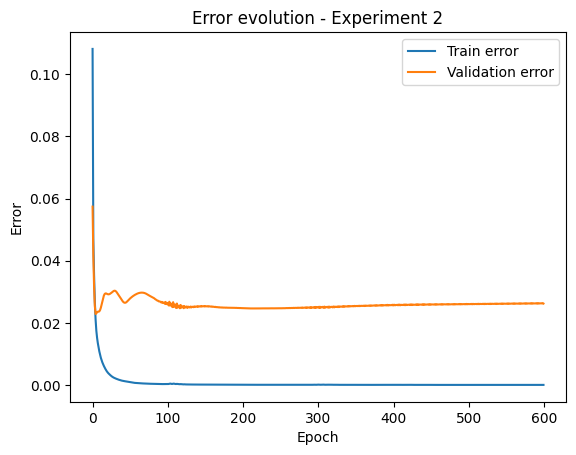

In [17]:
import matplotlib.pyplot as plt

# Recover the best experiment (same index order as all_results)
best_exp_idx = int(best_row["Experiment"]) - 1
best_exp = all_results[best_exp_idx]

train_err = best_exp["train_err"]
val_err   = best_exp["val_err"]

plt.figure()
plt.plot(train_err, label="Train error")
if any(v is not None for v in val_err):
    plt.plot(val_err, label="Validation error")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.title(f"Error evolution - Experiment {best_row['Experiment']}")
plt.show()
